
# 01 — Kou Jump–Diffusion Model 

In this notebook, we introduce Kou's jump diffusion model. We use it to simulate stock paths.  We compare stock paths generated by geometric Brownian motions and Kou's jump diffusion model.

**Model (Kou)**: The stock price $S_t$ follows
$$
S_t = S_0 \exp\Big\{ (\mu - \tfrac{1}{2}\sigma^2) t + \sigma W_t \Big\} \prod_{i=1}^{N_t} V_i,
$$
where $W_t$ is a standard Brownian motion, $N_t \sim \text{Poisson}(\lambda t)$, $V_i = e^{Y_i}$ are i.i.d's (jumps) with $Y_i =Y$ **double exponential**: with probability $p$, $Y\sim \text{Exp}(\eta_1)$ (up‑jump); with probability $q=1-p$, $Y\sim \text{Exp}(\eta_2)$ (down‑jump). More precisely, the probability density function of $Y$ is given by

$$
f_Y(y) = p \cdot \eta_1e^{-\eta_1y}\mathbb{1}_{\{y \geq 0\}} + q \cdot \eta_2e^{-\eta_2y}\mathbb{1}_{\{y < 0\}}, \ \ \ \ \eta_1 > 1, \eta_2 > 0.
$$

The requirement $\eta_1 >1$ is needed to ensure that $E(V_i) < \infty$ and $E(S_t) < \infty$.

> Under the **Risk‑neutral probability**, we have $\mu = r - \lambda \zeta$ and hence $$\log(S_t/S_0) = (r-\frac{1}{2}\sigma^2 -\lambda \zeta)\mathrm{d}t + \sigma\,\mathrm{d}W_t + \sum \limits_{i=1}^{N_t}Y_i$$
> where $\zeta = \mathbb{E}[e^Y]-1 = \frac{p\eta_1}{\eta_1-1} + \frac{q\eta_2}{\eta_2+1} - 1$, r is the risk-free interest rate

We implement an **exact** path simulator for the log process over small small time invervals $dt$ by the following idea: draw the jump *count* from $\text{Poisson}(\lambda dt)$, then draw a binomial *split* between up/down jumps and use **Gamma** shortcuts to sum jump sizes in each interval.


In [34]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For reproducibility
def rng(seed=None):
    return np.random.default_rng(seed)


In [35]:

def double_exponential_jump_sums(nums_jumps, p, eta1, eta2, rg):
    """
    return total jump sizes sum of Y_i's during a small time interval dt
    nums_jumps: array of numbers of jumps occuring during dt for different stock paths
    size of each jump Y_i is double exponential, namely +Exp(eta1) with probability p, 
    or -Exp(eta2) with probability 1-p.
    
    Vectorized implementation using a Binomial split and Gamma sums.

    total_Y = Sum_{j=1..nums_jumps} Y_j 
          = Gamma(nums_up_jumps, scale=1/eta1) /
            - Gamma(nums_down_jumps, scale=1/eta2).

    """
    nums_jumps = np.asarray(nums_jumps, dtype=np.int64)
    if nums_jumps.ndim == 0:
        nums_jumps = nums_jumps[None]
    
    # Divide all jumps into upward and downward jumps by binomial random draws
    nums_up_jumps = rg.binomial(nums_jumps, p)
    nums_down_jumps = nums_jumps - nums_up_jumps
    
    # Gamma(shape=nums_jumps, scale=1/eta). For k=0, we want 0, which means no jump. Handle zeros safely.
    total_Y_up = np.zeros_like(nums_jumps, dtype=float)
    up_jumps_indices = nums_up_jumps > 0 
    if up_jumps_indices.any():
        total_Y_up[up_jumps_indices] = rg.gamma(shape=nums_up_jumps[up_jumps_indices], scale=1.0/eta1)
    
    total_Y_down = np.zeros_like(nums_jumps, dtype=float)
    down_jumps_indices = nums_down_jumps > 0
    if down_jumps_indices.any():
        total_Y_down[down_jumps_indices] = rg.gamma(shape=nums_down_jumps[down_jumps_indices], scale=1.0/eta2)
    
    total_Y = total_Y_up - total_Y_down
    return total_Y.reshape(nums_jumps.shape)


In [36]:

def kou_paths(
    S0: float,
    T: float,
    n_steps: int,
    n_paths: int,
    sigma: float,
    lam: float,
    p: float,
    eta1: float,
    eta2: float,
    mu: float = None,
    r: float = None,
    seed: int = 42,
):
    """
    Simulate paths for Kou's double-exponential jump-diffusion.
    
    Args:
        S0: underlying stock price at time 0
        T: time to expiration in years
        n_steps: time steps
        n_paths: number of simulated paths
        sigma: yearly volatility
        lam: yearly jump intensity
        p: probability of up-jump (Y ~ +Exp(eta1)); q = 1 - p (down-jump Y ~ -Exp(eta2))
        eta1: rate of upward exponential; must satisfy eta1 > 1 for finite E[V]
        eta2: rate of downward exponential (> 0)
        mu: physical drift (use if r is None)
        r: risk-free interest rate; if provided, simulator uses risk-neutral drift (preferred for pricing)
        seed: RNG seed
    
    Returns:
        times (shape n_steps+1,), paths array (shape n_steps+1, n_paths)
    """
    assert S0 > 0 and T > 0 and n_steps >= 1 and n_paths >= 1
    assert sigma >= 0 and lam >= 0
    assert 0.0 <= p <= 1.0 and eta1 > 0 and eta2 > 0
    
    dt = T / n_steps
    rg = rng(seed)
    
    # Drift term in log S increment:
    if r is not None:
        # Risk-neutral drift uses zeta = E[e^Y]-1
        zeta = p * (eta1 / (eta1 - 1.0)) + (1.0 - p) * (eta2 / (eta2 + 1.0)) - 1.0
        mu_tilde = (r - 0.5 * sigma**2 - lam * zeta)
    else:
        if mu is None:
            raise ValueError("Provide either mu (physical) or r (risk-neutral).")
        mu_tilde = (mu - 0.5 * sigma**2)
    
    # Pre-allocate
    paths = np.empty((n_steps + 1, n_paths), dtype=float)
    paths[0, :] = S0
    sqrt_dt = np.sqrt(dt)
    
    # Draw Brownian increments and Poisson jump counts
    dW = rg.normal(loc=0.0, scale=sqrt_dt, size=(n_steps, n_paths))
    J = rg.poisson(lam=lam * dt, size=(n_steps, n_paths))
    
    # For each time step, compute jump-sum and log increment
    for t in range(n_steps):
        Y_sum = double_exponential_jump_sums(J[t], p=p, eta1=eta1, eta2=eta2, rg=rg)
        dX = mu_tilde * dt + sigma * dW[t] + Y_sum
        paths[t + 1] = paths[t] * np.exp(dX)
    
    times = np.linspace(0.0, T, n_steps + 1)
    return times, paths


In [39]:

def gbm_paths(S0, T, n_steps, n_paths, r, sigma, seed=42):
    """ 
    Simulate stock paths using geometric Brown motions under risk free assumption
    """
    dt = T / n_steps
    rg = rng(seed)
    dW = rg.normal(0.0, np.sqrt(dt), size=(n_steps, n_paths))
    X = (r - 0.5 * sigma**2) * dt + sigma * dW  # per-step log-return increments
    logS = np.vstack([np.zeros((1, n_paths)), np.cumsum(X, axis=0)])
    return np.linspace(0.0, T, n_steps + 1), S0 * np.exp(logS)



## Demo: 10 paths (Kou) vs. GBM (visual)
We simulate **10 Kou paths** using plausible parameters and plot them. Then we show the **GBM limit** by setting $\lambda=0$.


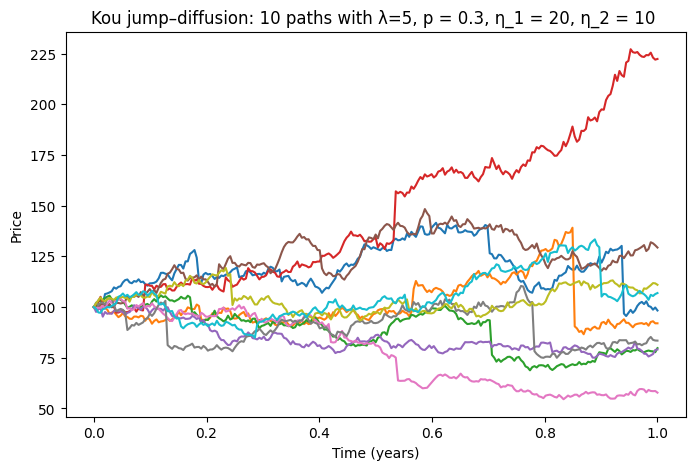

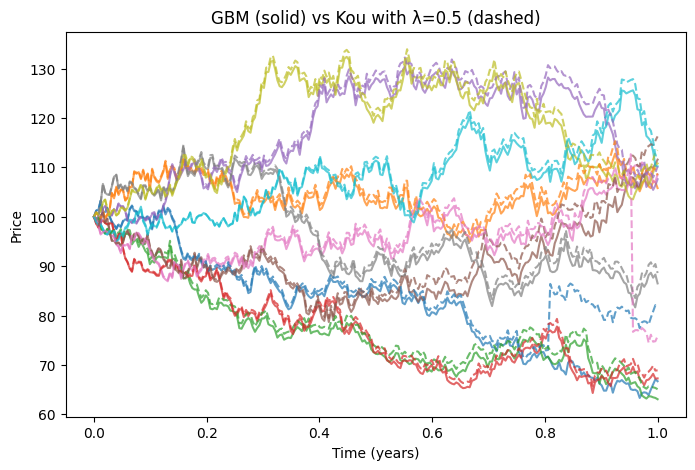

In [129]:

# Parameters
S0    = 100.0
T     = 1.0
steps = 252
paths = 10

sigma = 0.2
lam   = 5       # avg 3 jumps per year
p     = 0.3       # 30% upward jumps
eta1  = 20.0      # avg up-jump size ~ 1/eta1 = 4% (in log)
eta2  = 10     # avg down-jump magnitude ~ 1/eta2 = 8%
r     = 0.03

t, S_kou = kou_paths(S0, T, steps, paths, sigma, lam, p, eta1, eta2, r=r, seed=None)

plt.figure(figsize=(8,5))
plt.plot(t, S_kou)
plt.title("Kou jump–diffusion: 10 paths with λ=5, p = 0.3, η_1 = 20, η_2 = 10 ")
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.show()

# GBM vs Kou (λ=0)
# Here we use one fresh seed and reuse it for both calls so the curves coincide,
# while changing every time you execute the cell.
seed_same = np.random.default_rng().integers(0, 2**32 - 1, dtype=np.uint32).item()

t_gbm, S_gbm = gbm_paths(S0, T, steps, paths, r=r, sigma=sigma, seed=seed_same)
t_kou, S_kou = kou_paths(S0, T, steps, paths, sigma, lam=0.5, p=p, eta1=eta1, eta2=eta2, r=r, seed=seed_same)

plt.figure(figsize=(8,5))
plt.plot(t_gbm, S_gbm, alpha=0.7)
plt.plot(t_kou, S_kou, linestyle="--", alpha=0.7)
plt.title("GBM (solid) vs Kou with λ=0.5 (dashed)")
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.show()


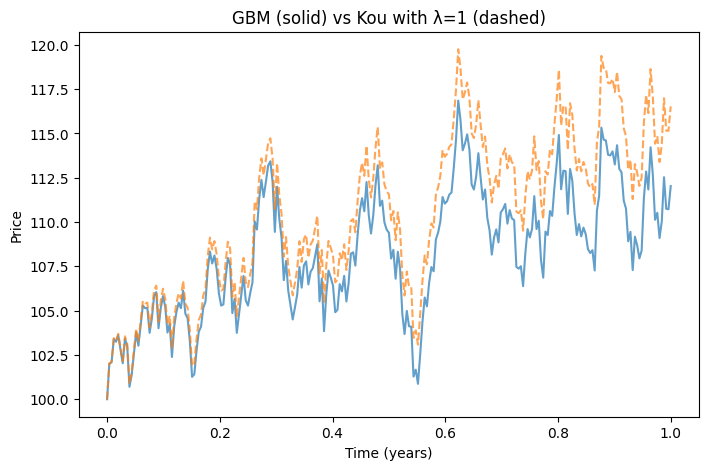

In [106]:
#Further comparison betweeen GBM path and Kou's path, even very small lambda can make big diffirence
S0    = 100.0
T     = 1.0
steps = 252
paths = 1

sigma = 0.2
lam   = 1      # avg jumps per year
p     = 0.3       # 30% upward jumps
eta1  = 25.0      # avg up-jump size ~ 1/eta1 = 4% (in log)
eta2  = 12.5      # avg down-jump magnitude ~ 1/eta2 = 8%
r     = 0.03

seed_same = np.random.default_rng().integers(0, 2**32 - 1, dtype=np.uint32).item()

t_gbm, S_gbm = gbm_paths(S0, T, steps, paths, r=r, sigma=sigma, seed=seed_same)
t_kou, S_kou = kou_paths(S0, T, steps, paths, sigma, lam=lam, p=p, eta1=eta1, eta2=eta2, r=r, seed=seed_same)

plt.figure(figsize=(8,5))
plt.plot(t_gbm, S_gbm, alpha=0.7)
plt.plot(t_kou, S_kou, linestyle="--", alpha=0.7)
plt.title("GBM (solid) vs Kou with λ=1 (dashed)")
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.show()


## Quick Tests
1. **GBM limit**: with $\lambda=0$, Kou paths should match GBM (same seed).

2. **Finite $\mathbb{E}[V]$**: requires $\eta_1 > 1$. Code asserts this implicitly via risk‑neutral drift when needed.

3. **Shapes** and **reproducibility**.


In [7]:

# 1) GBM limit test (tight tolerance because increments are exactly matched)
_, S1 = gbm_paths(100, 1.0, 252, 4, mu=0.05, sigma=0.2, seed=123)
_, S2 = kou_paths(100, 1.0, 252, 4, sigma=0.2, lam=0.0, p=0.3, eta1=25.0, eta2=12.5, r=0.05, seed=123)
assert np.allclose(S1, S2, atol=1e-12), "GBM and Kou(λ=0) should match exactly with same seed."

# 2) Shapes
_, S = kou_paths(100, 1.0, 64, 7, sigma=0.2, lam=2.0, p=0.4, eta1=20.0, eta2=10.0, r=0.03, seed=7)
assert S.shape == (65, 7)

# 3) Reproducibility
_, S_a = kou_paths(100, 1.0, 64, 7, sigma=0.2, lam=2.0, p=0.4, eta1=20.0, eta2=10.0, r=0.03, seed=7)
_, S_b = kou_paths(100, 1.0, 64, 7, sigma=0.2, lam=2.0, p=0.4, eta1=20.0, eta2=10.0, r=0.03, seed=7)
assert np.allclose(S_a, S_b), "Paths should be identical under same seed."

print("All quick tests passed ✓")


All quick tests passed ✓



## Jump moments: $\zeta$ and a basic Monte Carlo check
We verify that the empirical mean of $e^{Y}$ is close to the closed‑form value
$\mathbb{E}[V] = \frac{p\eta_1}{\eta_1-1} + \frac{(1-p)\eta_2}{\eta_2+1}$.


In [8]:

def zeta_E_V_minus_1(p, eta1, eta2):
    EV = p * (eta1 / (eta1 - 1.0)) + (1.0 - p) * (eta2 / (eta2 + 1.0))
    return EV - 1.0, EV

rg = rng(2025)
p, eta1, eta2 = 0.3, 25.0, 12.5
# Draw many Y ~ double-exponential
N = 500_000
is_up = rg.random(N) < p
Y = np.empty(N)
Y[is_up]  = rg.exponential(scale=1.0/eta1, size=is_up.sum())
Y[~is_up] = -rg.exponential(scale=1.0/eta2, size=(~is_up).sum())

EV_emp = np.exp(Y).mean()
zeta_cf, EV_cf = zeta_E_V_minus_1(p, eta1, eta2)
print(f"Closed form E[V]: {EV_cf:.6f} | Empirical E[V]: {EV_emp:.6f} | zeta = {zeta_cf:.6f}")


Closed form E[V]: 0.960648 | Empirical E[V]: 0.960645 | zeta = -0.039352
